In [1]:
%load_ext autoreload
%autoreload 2
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, InputLayer
from keras.layers.convolutional import Conv2D, MaxPooling2D
import sys
import os
pwd = os.getcwd()
sys.path.append("/root/Gan/jidian/MLexperiments")
sys.path.append("/root/Gan/jidian")
sys.path.append(pwd)
sys.path.append(os.path.dirname(os.getcwd()))
import MLexperiments.classes
from MLexperiments.classes import ReadAutoLabeledData
import tensorflow as tf
import MLexperiments.config.parameters
from keras.layers import LSTM, Reshape
import matplotlib.pyplot as plt
import utils
from keras.callbacks import ModelCheckpoint
import os
from keras.callbacks import TensorBoard
from time import time
from keras.models import Model
from keras.layers import Input, Dense
import datetime
import Models
import os, errno


In [3]:
#+12h = chinese time zone


#
tf.flags.DEFINE_integer("BATCH_SIZE",128, "size")
tf.flags.DEFINE_integer("MODEL_TYPE",0 , "0: CNN, 1:RNN")
tf.flags.DEFINE_string("CHECKPOINTPATH",'logs/{}'.format(datetime.datetime.fromtimestamp(time()).strftime('%Y-%m-%d %H:%M:%S'))\
                       , "Path to save the best models")
tf.flags.DEFINE_string("MODE",  3\
                       , " mode is data source specification;   mode: 1 => 3 human + rain: 1 means high only, 2 high + mid, 3 high+mid+low ,4=>6 man + rain + wind:      4 means high only, 5 high + mid, 6 high+mid+low , 7 => qinshang + factory for testing")

FLAGS = tf.flags.FLAGS
FLAGS._parse_flags()

['-f', '/run/user/0/jupyter/kernel-5cb5ec4f-cfa2-4247-ba4d-1806cbb91cd8.json']

In [4]:
FLAGS.CHECKPOINTPATH = FLAGS.CHECKPOINTPATH + "prep for transfer;all data training 12000+data"
SAVE_BEST_ONLY = False
FLAGS.MODE = 11

In [5]:
#data reading and initialization

try:
    os.makedirs(FLAGS.CHECKPOINTPATH)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise


In [6]:
myDataSet = utils.read_data_sets(one_hot=True, test_size = 0.01, validation_size = 0.1, fake_data = False\
                                , mode = FLAGS.MODE
                                )

(X_train, y_train), (X_test, y_test) , (X_Ftest, y_Ftest)= (myDataSet.train.images, myDataSet.train.labels), (myDataSet.validation.images, myDataSet.validation.labels), (myDataSet.test.images, myDataSet.test.labels)

print(X_train[0].shape)
print(y_train[0])

X_train = X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
X_Ftest = X_Ftest.reshape(X_Ftest.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')

#X_train /= 255
#X_test /= 255


def tran_y(y):
    y_ohe = np.zeros(MLexperiments.config.parameters.OUTPUTNUM)
    
    y_ohe[int(y)] = 1 
    return y_ohe

# def tran_y(y):
#     y_ohe = np.zeros(MLexperiments.config.parameters.OUTPUTNUM)
#     if y:
#         y_ohe[1] = 1
#     else:
#         y_ohe[0] = 1
#     return y_ohe
# def tran_y(y):
#     return y
#import pdb;pdb.set_trace()
y_train_ohe = np.array([tran_y(y_train[i]) for i in range(len(y_train))])
y_test_ohe = np.array([tran_y(y_test[i]) for i in range(len(y_test))])

y_Ftest_ohe = np.array([tran_y(y_Ftest[i]) for i in range(len(y_Ftest))])

loading mode = 11(np_input, labelData = np.concatenate((qinshang_man_input, rain_input,qinshang_man_input2, rain_input2,qinshang_man_input3, rain_input3)), np.concatenate((qinshang_man_label, rain_label,qinshang_man_label2, rain_label2,qinshang_man_label3, rain_label3))
number of each type (balanced):
14053
total (balanced):
28106
 np_input shape:  (28106, 100, 10) labelData shape:  (28106,)
read succesful
(1000,)
0.0


In [7]:
# print("loading training data")
# myDataSet = utils.read_data_sets(one_hot=True, test_size = 0.01, validation_size = 0.01, fake_data = False\
#                                 , mode = 3
#                                 )

# (X_train, y_train), (_, _) , (_, _)= (myDataSet.train.images, myDataSet.train.labels), (myDataSet.validation.images, myDataSet.validation.labels), (myDataSet.test.images, myDataSet.test.labels)

# print("loading testing data")
# myDataSet = utils.read_data_sets(one_hot=True, test_size = 0.5, validation_size = 1.0, fake_data = False\
#                                 , mode = 10
#                                 )

# (_, _), (X_test, y_test) , (X_Ftest, y_Ftest)= (myDataSet.train.images, myDataSet.train.labels), (myDataSet.validation.images, myDataSet.validation.labels), (myDataSet.test.images, myDataSet.test.labels)


# print(X_train[0].shape)
# print(y_train[0])

# X_train = X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
# X_test = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
# X_Ftest = X_Ftest.reshape(X_Ftest.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')

# #X_train /= 255
# #X_test /= 255


# def tran_y(y):
#     y_ohe = np.zeros(MLexperiments.config.parameters.OUTPUTNUM)
    
#     y_ohe[int(y)] = 1 
#     return y_ohe

# # def tran_y(y):
# #     y_ohe = np.zeros(MLexperiments.config.parameters.OUTPUTNUM)
# #     if y:
# #         y_ohe[1] = 1
# #     else:
# #         y_ohe[0] = 1
# #     return y_ohe
# # def tran_y(y):
# #     return y
# #import pdb;pdb.set_trace()
# y_train_ohe = np.array([tran_y(y_train[i]) for i in range(len(y_train))])
# y_test_ohe = np.array([tran_y(y_test[i]) for i in range(len(y_test))])

# y_Ftest_ohe = np.array([tran_y(y_Ftest[i]) for i in range(len(y_Ftest))])

In [8]:
model = Models.getMODEL(FLAGS.MODEL_TYPE)

#model.load_weights("/root/Gan/jidian/MLexperiments/scripts/logs/2017-10-30 03:36:13/best_weights.hdf5")
#model.load_weights("best_weights.hdf5", by_name=True)
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

#model.load_weights("/root/Gan/jidian/MLexperiments/scripts/logs/2017-10-30 03:36:13/best_weights.hdf5")
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        self.is_start = True
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
    def on_train_begin(self, logs={}):
        if self.is_start:
            self.losses = []
            self.val_losses = []
            self.acc = []
            self.val_acc = []
            self.is_start = False
            
            

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
lossHistory = LossHistory()
checkpointer = ModelCheckpoint(filepath = os.path.join(FLAGS.CHECKPOINTPATH, 'weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'), verbose=1, save_best_only=SAVE_BEST_ONLY)
tensorboard = TensorBoard(log_dir=FLAGS.CHECKPOINTPATH,histogram_freq=0, batch_size=FLAGS.BATCH_SIZE, write_graph=True, write_grads=False, \
                          write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

model.summary()
#



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 8, 64)         640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 8, 64)         256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 8, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 6, 128)        73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 6, 128)        512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 6, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 6, 32)         4128      
__________

In [9]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5,6"

history = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=100, batch_size=FLAGS.BATCH_SIZE, \
                callbacks=[\
                           lossHistory,\
                           checkpointer,\
                           tensorboard\
                          ] )

Train on 25042 samples, validate on 2782 samples
Epoch 1/100
25042/25042 [==============================] - 10s - loss: 0.4058 - acc: 0.8449 - val_loss: 0.7451 - val_acc: 0.5025
Epoch 2/100
25042/25042 [==============================] - 8s - loss: 0.2187 - acc: 0.9205 - val_loss: 1.1915 - val_acc: 0.5025
Epoch 3/100
25042/25042 [==============================] - 8s - loss: 0.1791 - acc: 0.9395 - val_loss: 0.3991 - val_acc: 0.7757
Epoch 4/100
25042/25042 [==============================] - 8s - loss: 0.1508 - acc: 0.9532 - val_loss: 0.3468 - val_acc: 0.8314
Epoch 5/100
25042/25042 [==============================] - 8s - loss: 0.1467 - acc: 0.9554 - val_loss: 0.2985 - val_acc: 0.8544
Epoch 6/100
25042/25042 [==============================] - 8s - loss: 0.1332 - acc: 0.9591 - val_loss: 0.2687 - val_acc: 0.9188
Epoch 7/100
25042/25042 [==============================] - 8s - loss: 0.1263 - acc: 0.9620 - val_loss: 0.1608 - val_acc: 0.9378
Epoch 8/100
25042/25042 [=============================

25042/25042 [==============================] - 8s - loss: 0.0757 - acc: 0.9779 - val_loss: 0.0924 - val_acc: 0.9705
Epoch 25/100
25042/25042 [==============================] - 8s - loss: 0.0741 - acc: 0.9778 - val_loss: 0.0835 - val_acc: 0.9723
Epoch 26/100
25042/25042 [==============================] - 8s - loss: 0.0730 - acc: 0.9786 - val_loss: 0.1564 - val_acc: 0.9479
Epoch 27/100
25042/25042 [==============================] - 8s - loss: 0.0753 - acc: 0.9780 - val_loss: 0.1585 - val_acc: 0.9493
Epoch 28/100
25042/25042 [==============================] - 8s - loss: 0.0665 - acc: 0.9814 - val_loss: 0.1226 - val_acc: 0.9605
Epoch 29/100
25042/25042 [==============================] - 8s - loss: 0.0654 - acc: 0.9810 - val_loss: 0.0702 - val_acc: 0.9795
Epoch 30/100
25042/25042 [==============================] - 8s - loss: 0.0663 - acc: 0.9800 - val_loss: 0.1053 - val_acc: 0.9655
Epoch 31/100
25042/25042 [==============================] - 8s - loss: 0.0667 - acc: 0.9810 - val_loss: 0.1069

25042/25042 [==============================] - 8s - loss: 0.0501 - acc: 0.9854 - val_loss: 0.0624 - val_acc: 0.9802
Epoch 49/100
25042/25042 [==============================] - 8s - loss: 0.0495 - acc: 0.9849 - val_loss: 0.0914 - val_acc: 0.9720
Epoch 50/100
25042/25042 [==============================] - 8s - loss: 0.0489 - acc: 0.9860 - val_loss: 0.0879 - val_acc: 0.9730
Epoch 51/100
25042/25042 [==============================] - 8s - loss: 0.0500 - acc: 0.9868 - val_loss: 0.1278 - val_acc: 0.9637
Epoch 52/100
25042/25042 [==============================] - 8s - loss: 0.0464 - acc: 0.9863 - val_loss: 0.0806 - val_acc: 0.9748
Epoch 53/100
25042/25042 [==============================] - 8s - loss: 0.0430 - acc: 0.9870 - val_loss: 0.1159 - val_acc: 0.9666
Epoch 54/100
25042/25042 [==============================] - 8s - loss: 0.0434 - acc: 0.9873 - val_loss: 0.0924 - val_acc: 0.9727
Epoch 55/100
25042/25042 [==============================] - 8s - loss: 0.0469 - acc: 0.9870 - val_loss: 0.0896

25042/25042 [==============================] - 8s - loss: 0.0404 - acc: 0.9887 - val_loss: 0.1018 - val_acc: 0.9702
Epoch 73/100
25042/25042 [==============================] - 8s - loss: 0.0366 - acc: 0.9891 - val_loss: 0.1083 - val_acc: 0.9694
Epoch 74/100
25042/25042 [==============================] - 8s - loss: 0.0344 - acc: 0.9899 - val_loss: 0.0915 - val_acc: 0.9723
Epoch 75/100
25042/25042 [==============================] - 8s - loss: 0.0365 - acc: 0.9895 - val_loss: 0.1060 - val_acc: 0.9698
Epoch 76/100
25042/25042 [==============================] - 8s - loss: 0.0359 - acc: 0.9903 - val_loss: 0.0541 - val_acc: 0.9838
Epoch 77/100
25042/25042 [==============================] - 8s - loss: 0.0345 - acc: 0.9898 - val_loss: 0.0624 - val_acc: 0.9781
Epoch 78/100
25042/25042 [==============================] - 8s - loss: 0.0355 - acc: 0.9900 - val_loss: 0.0389 - val_acc: 0.9892
Epoch 79/100
25042/25042 [==============================] - 9s - loss: 0.0381 - acc: 0.9892 - val_loss: 0.0688

25042/25042 [==============================] - 8s - loss: 0.0309 - acc: 0.9907 - val_loss: 0.1295 - val_acc: 0.9669
Epoch 97/100
25042/25042 [==============================] - 8s - loss: 0.0286 - acc: 0.9921 - val_loss: 0.0577 - val_acc: 0.9845
Epoch 98/100
25042/25042 [==============================] - 8s - loss: 0.0288 - acc: 0.9917 - val_loss: 0.0571 - val_acc: 0.9838
Epoch 99/100
25042/25042 [==============================] - 8s - loss: 0.0268 - acc: 0.9921 - val_loss: 0.0503 - val_acc: 0.9842
Epoch 100/100
25042/25042 [==============================] - 8s - loss: 0.0277 - acc: 0.9922 - val_loss: 0.0641 - val_acc: 0.9827


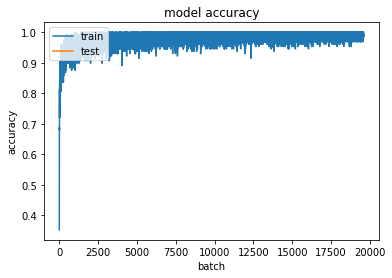

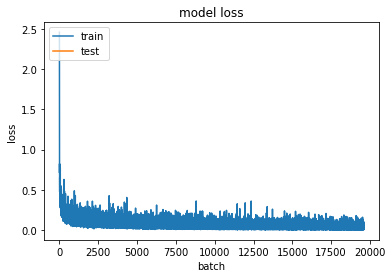

In [10]:

# summarize history for accuracy
plt.plot(lossHistory.acc)
plt.plot(lossHistory.val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(lossHistory.losses)
plt.plot(lossHistory.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

scores = model.evaluate(X_Ftest, y_Ftest_ohe, verbose=0)

In [11]:
scores

[0.052854385722762118, 0.98581560283687941]

expected: 1.0
prediction:1


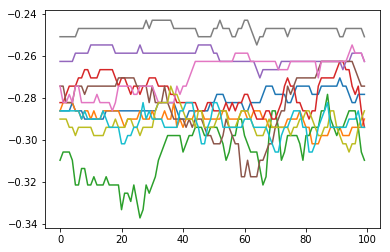

expected: 1.0
prediction:1


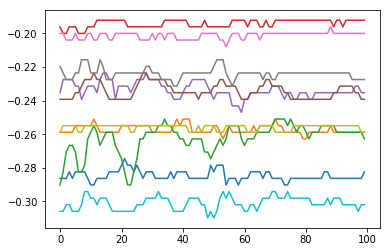

expected: 0.0
prediction:0


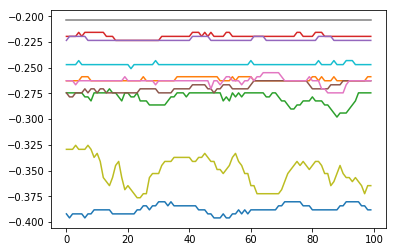

expected: 1.0
prediction:1


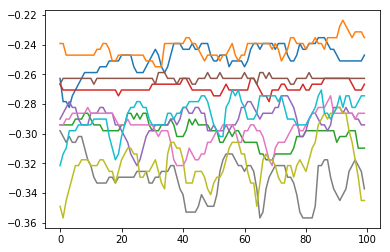

expected: 0.0
prediction:0


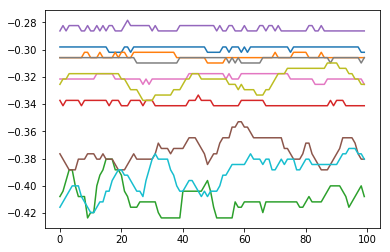

expected: 0.0
prediction:0


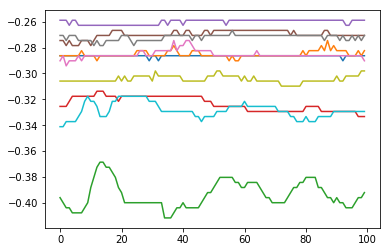

expected: 0.0
prediction:0


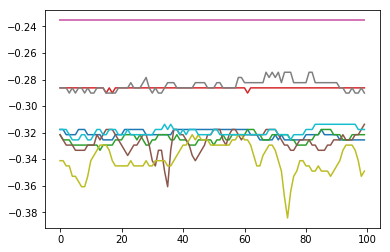

expected: 1.0
prediction:1


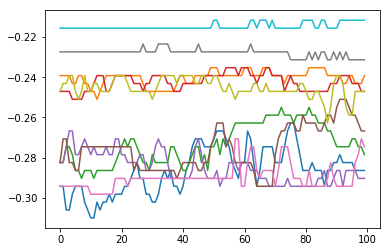

expected: 1.0
prediction:1


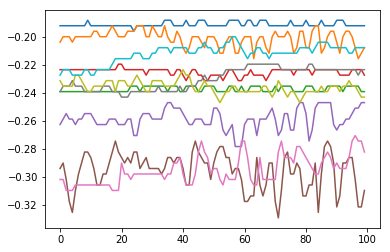

expected: 1.0
prediction:1


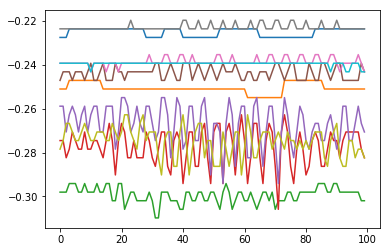

In [12]:

for index in range(10):
    print("expected: "+str( y_Ftest[index]))
    prediction = model.predict(np.expand_dims(X_Ftest[index], axis=0))[0]
    print("prediction:" + str(np.argmax(prediction,axis = 0)))
    time_series = X_Ftest.reshape(X_Ftest.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
        .astype('float32')[index]
    # plt.imshow( X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT).astype('float32')[0]);
    # plt.colorbar()
    # plt.show()
    plt.plot(time_series.T[0])
    plt.plot(time_series.T[1])
    plt.plot(time_series.T[2])
    plt.plot(time_series.T[3])
    plt.plot(time_series.T[4])
    plt.plot(time_series.T[5])
    plt.plot(time_series.T[6])
    plt.plot(time_series.T[7])
    plt.plot(time_series.T[8])
    plt.plot(time_series.T[9])
    plt.show()
   

In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [14]:
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# datagen = ImageDataGenerator(
#        vertical_flip=False,
#         horizontal_flip=True)

# index = 0
# time_series = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
#         .astype('float32')[index]

# # plt.plot(time_series.T[0])
# # plt.show()    
# # plt.plot(time_series.T[1])
# # plt.show()    
# # plt.plot(time_series.T[2])
# # plt.show()    
# # plt.plot(time_series.T[3])
# # plt.show()    
# # plt.plot(time_series.T[4])
# # plt.show()    
# # plt.plot(time_series.T[5])
# # plt.show()    
# # print("+++++++++++++++++++++++++++++++++++++++++++++")    
    
    
# # img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
# # x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# # x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
# x = time_series.reshape((1,)+time_series.shape + (1,))
# print("x.shape  ")
# print(x.shape)
# # the .flow() command below generates batches of randomly transformed images
# # and saves the results to the `preview/` directory
# i = 0
# for batch in datagen.flow(x, batch_size=1):
#     i += 1
#     time_series = batch[0]
#     time_series = time_series.reshape( MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
#         .astype('float32')
#     plt.plot(time_series.T[0])
#     plt.plot(time_series.T[1])
#     plt.plot(time_series.T[2])
#     plt.plot(time_series.T[3])
#     plt.plot(time_series.T[4])
#     plt.plot(time_series.T[5])
#     plt.show()
# #     plt.plot(time_series.T[0])
# #     plt.show()    
# #     plt.plot(time_series.T[1])
# #     plt.show()    
# #     plt.plot(time_series.T[2])
# #     plt.show()    
# #     plt.plot(time_series.T[3])
# #     plt.show()    
# #     plt.plot(time_series.T[4])
# #     plt.show()    
# #     plt.plot(time_series.T[5])
# #     plt.show()    
# #     print("+++++++++++++++++++++++++++++++++++++++++++++")    
    
#     if i > 3:
#         break  # otherwise the generator would loop indefinitely

In [23]:
num = 0
'hanning%s.pdf' % num

'hanning0.pdf'